In [1]:
import torch
import torchvision
from torch.optim import Adam
from PIL import Image
from data_utils.pre_process import load_image_paths_from_folder, load_images_and_labels, load_datasets, load_image_path_splits, preprocess_mask
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
import torch
import pytest
from lightning.pytorch import Trainer
from models.model_blocks import (
    UNetDecoderBlock,
    UNetEncoderBlock,
    UNetMidBlock,
    UNetDecoder,
    UNetEncoder
)
from models.unet import UNet

In [2]:
input_folder_path = "oxford-iiit-pet/images"
label_folder_path = "oxford-iiit-pet/annotations/trimaps"
imgs = load_image_paths_from_folder(input_folder_path)
labels = load_image_paths_from_folder(label_folder_path)

In [3]:
input_folder_path = "oxford-iiit-pet/images"
label_folder_path = "oxford-iiit-pet/annotations/trimaps"

input_images, label_images = load_images_and_labels(input_folder_path=input_folder_path,
                                                    label_folder_path=label_folder_path)

train_transforms = A.Compose([
    A.Resize(300, 300),
    A.HorizontalFlip(p=0.5),                  
    A.RandomCrop(height=256, width=256), 
    A.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225],
                        max_pixel_value=255.0,
                        normalization="standard", # Default
                        p=1.0),
    A.ToTensorV2()                            
])

val_test_transforms = A.Compose([
    A.Resize(300, 300),
    A.HorizontalFlip(p=0.5),                  
    A.RandomCrop(height=256,width=256),
    A.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                normalization="standard", # Default
                p=1.0),
    A.ToTensorV2()                          
])

train_dataset, val_dataset, test_dataset = load_datasets(input_images, 
                                                            label_images, 
                                                            train_transforms,
                                                            val_test_transforms,
                                                            shuffle=True,
                                                            save_path="saved_data")

/var/folders/3l/q_yssm517fj86sqc7nn2zrcm0000gn/T/ipykernel_17817/626533111.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:4419.)
  axes[1,0].imshow(np.clip(trans_img.T, 0, 1))


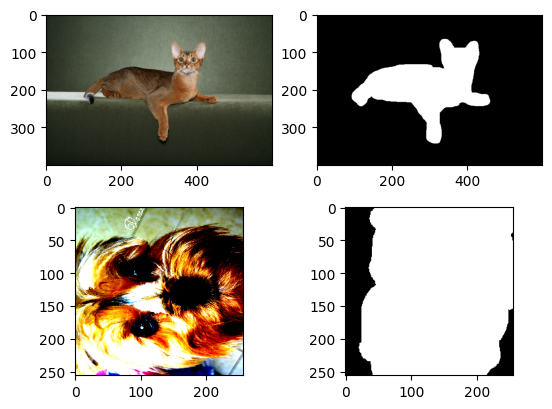

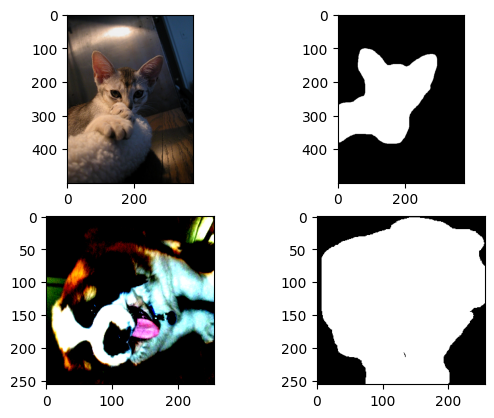

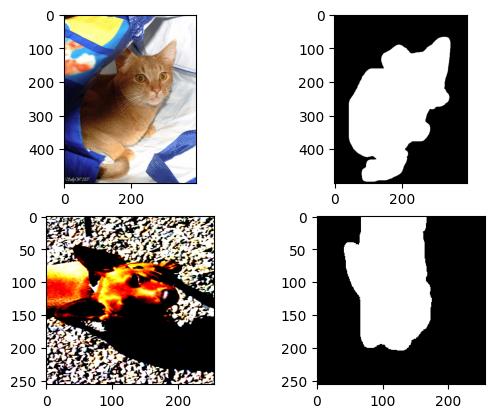

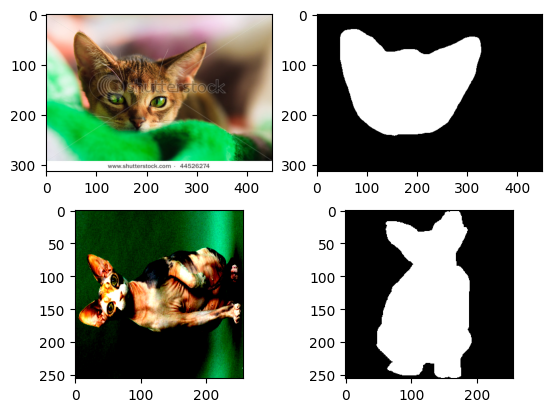

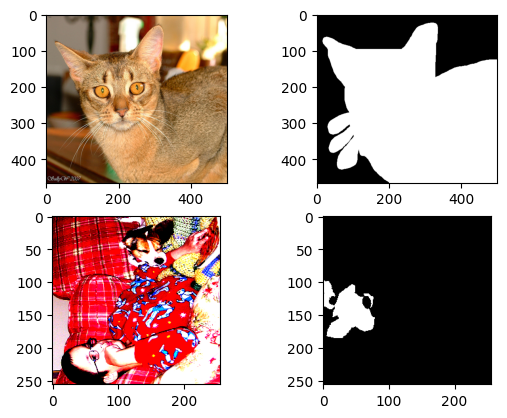

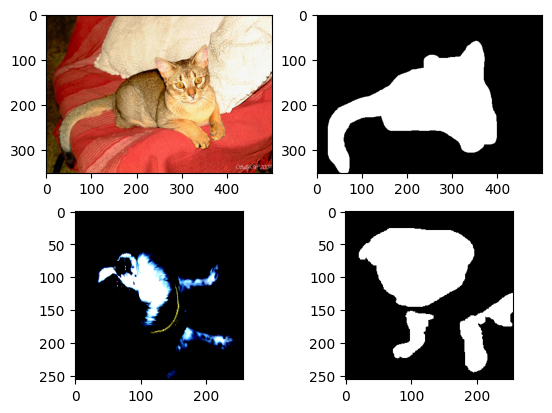

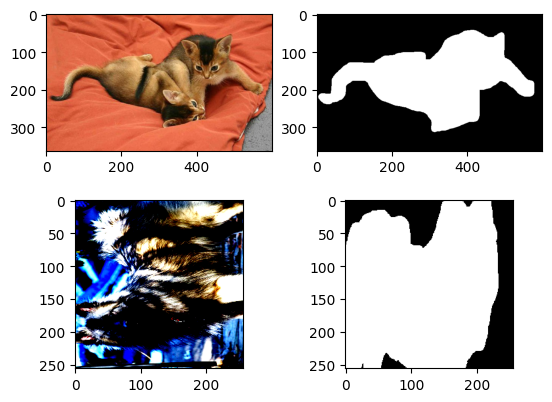

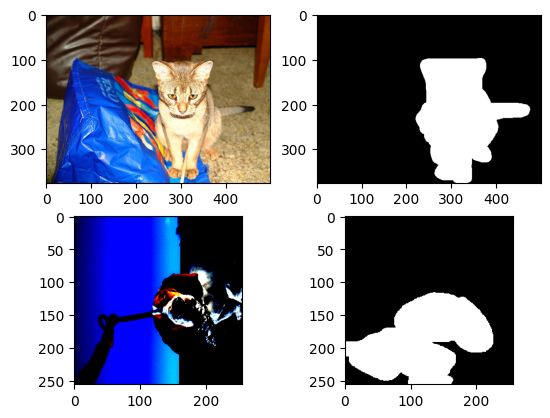

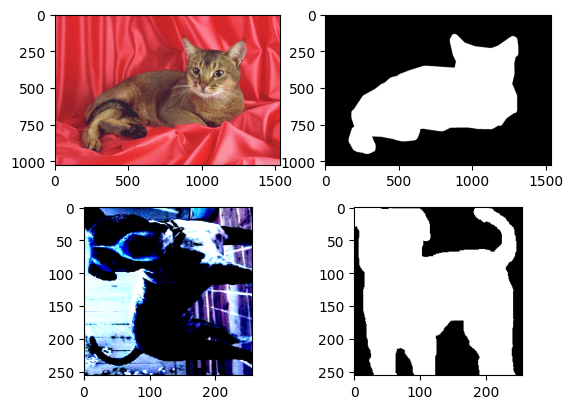

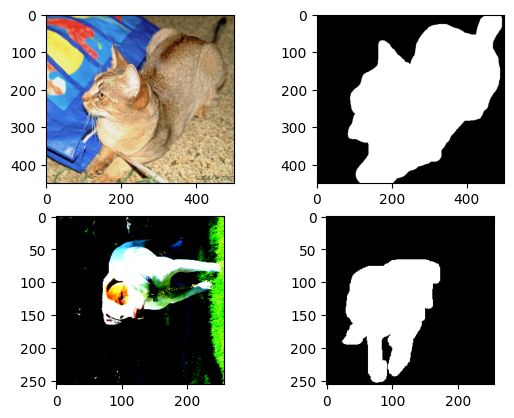

In [4]:
for i in range(10):
    fig, axes = plt.subplots(2,2)
    original_img, original_segment = np.asarray(Image.open(input_images[i])), preprocess_mask(np.asarray(Image.open(label_images[i])))
    trans_img, trans_segment = train_dataset.__getitem__(i)

    axes[0,0].imshow(original_img)
    axes[0,1].imshow(original_segment, cmap='gray')

    axes[1,0].imshow(np.clip(trans_img.T, 0, 1))
    axes[1,1].imshow(np.squeeze(trans_segment), cmap='grey')

    plt.show()
    

In [5]:
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch import Trainer
import wandb
from models.unet import UNet, ImageSegmentationModel
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
import yaml
from data_utils.pre_process import load_datasets, load_images_and_labels
import albumentations as A
from torch.utils.data import DataLoader
import torch

unet = UNet(in_channels=3, 
        out_channels=64,
        kernel_size=3, 
        final_filters=1,
        encoder_dropout=0.2)

loss_criterion = torch.nn.BCEWithLogitsLoss()

segmentation_model = ImageSegmentationModel(model = unet,
                                            loss_function = loss_criterion,
                                            lr = 0.000001,
                                            scheduler_step = 10,
                                            scheduler_gamma = 0.5)

logger = WandbLogger(log_model=True)

callbacks = [EarlyStopping(monitor="val_loss", mode="min"), 
            LearningRateMonitor(logging_interval='step'),
            ModelCheckpoint(
            monitor="val_loss",      # metric to monitor
            mode="min",              # "min" for loss, "max" for accuracy/IoU
            save_top_k=1,            # save ONLY the best model
            save_last=False,         # don't save last epoch
            filename="best-{epoch}-{val_loss:.4f}",
        )]

batch_size = 32
train_dataloader = DataLoader(train_dataset, 
                                batch_size=batch_size,
                                shuffle=True,
                                num_workers=1,
                                persistent_workers=True)

val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False,
                            num_workers=1,
                            persistent_workers=True)

test_dataloader = DataLoader(test_dataset,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=1,
                                persistent_workers=True)

trainer = Trainer(
    logger=logger,
    max_epochs=100, # Epochs in config
    callbacks=callbacks,
    accelerator="mps",
    log_every_n_steps=32
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


In [6]:
trainer.fit(segmentation_model, train_dataloader, val_dataloader)

wandb: WARNING The anonymous setting has no effect and will be removed in a future version.
wandb: WARNING Failed to create global config settings in: /Users/louisgodtfredsen/.config/wandb. Settings will not be persisted.
wandb: Currently logged in as: louis-godtfredsen to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



  | Name          | Type              | Params | Mode  | FLOPs
--------------------------------------------------------------------
0 | model         | UNet              | 45.2 M | train | 0    
1 | loss_function | BCEWithLogitsLoss | 0      | train | 0    
--------------------------------------------------------------------
45.2 M    Trainable params
0         Non-trainable params
45.2 M    Total params
180.754   Total estimated model params size (MB)
51        Modules in train mode
0         Modules in eval mode
0         Total Flops


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/louisgodtfredsen/Desktop/Coding Projects/ImageSegmentation/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/louisgodtfredsen/Desktop/Coding Projects/ImageSegmentation/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 1:  36%|███▌      | 58/162 [14:40<26:18,  0.07it/s, v_num=ec2v, train_loss_step=1.040, val_loss=1.030, train_loss_epoch=1.050] 


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/Users/louisgodtfredsen/Desktop/Coding Projects/ImageSegmentation/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3709: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


Error in callback <bound method _WandbInit._post_run_cell_hook of <wandb.sdk.wandb_init._WandbInit object at 0x16555c320>> (for post_run_cell), with arguments args (<ExecutionResult object at 164b75c70, execution_count=6 error_before_exec=None error_in_exec=1 info=<ExecutionInfo object at 164b771d0, raw_cell="trainer.fit(segmentation_model, train_dataloader, .." transformed_cell="trainer.fit(segmentation_model, train_dataloader, .." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/Users/louisgodtfredsen/Desktop/Coding%20Projects/ImageSegmentation/unet_test.ipynb#X31sZmlsZQ%3D%3D> result=None>,),kwargs {}:


ConnectionResetError: Connection lost

In [6]:
for i in range(train_dataset.__len__()):
    x, y = train_dataset.__getitem__(i)

    if x.shape != (3, 256, 256):
        print(f'X input shape wrong at index: {i}')

    if y.shape != (1, 256, 256):
        print(f'y input shape wrong at index: {i}')